# Home Credit Default Risk 

In this notebook, I'm going to predict the probability of loan default risk base on partial data from the [Home Credit default risk machine learning competition](https://www.kaggle.com/c/home-credit-default-risk/) in Kaggle. The goal of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a supervised learning task and classification problem.


## Data

In this notebook, I'm using only the application_train.csv which is 1 file out of 7.
This file is the main table, static data for all applications which one row represents one loan in the data sample.

The description of the columns is in the columns_description.csv , this is a reduced version that describes the application set only.

The data contains 307,511 rows (each row represents a loan) and 122 columns represent information about the client and the loan.

Link to the full data source: https://www.kaggle.com/c/home-credit-default-risk/data


## Metric

In this case, we are dealing with imbalanced data (most of the clients repay their loan) so accuracy matric is not relevant.
So, the metric that we are going to check is the [Receiver Operating Characteristic Area Under the Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC AUC).

**Reminder**: ROC curve is the true positive rate versus the false positive rate.
The Area Under the Curve (AUC) is the integral of the curve (ROC). This metric provides scores between 0 and 1, higher-score means a better model. A random guessing model will have a ROC AUC score of 0.5.


## Results

The XGBoost provides the best performance from all the algorithms I used (including ANN).
The test ROC AUC score is: **0.7689**.

In order to make a comparison, we can look at the best score from this competition which is 0.81 (by using all data files).


## Notebook Content

- Import Data and Libraries
- Exploratory Data Analysis (EDA)
- Data cleaning
- Dealing with Na's
- Feature Engineering
- Data Preparation for Modeling
- Models
- Machine Learning Algorithms
- Hyperparameter Tuning
- Deep Neural Network
- Best Results
- Feature Importances


# Import Data and Libraries 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , StratifiedKFold, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler ,LabelEncoder

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings(action="ignore")


import keras
from keras.layers import Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier


%matplotlib inline

C:\Users\tomer\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
application = pd.read_csv(r'C:\Users\tomer\Downloads\application_train.csv')
print(application.shape,'\n')

application.columns = application.columns.str.lower()
application.drop(columns=['sk_id_curr'], inplace=True)

(307511, 122) 



### Split The Data 

First let's split the data to train (data) and test (holdout).

In [4]:
data, holdout = train_test_split(application, test_size = 0.2 ,stratify = application['target'] # split proportional to the target classes balance
                                , random_state=123)

data.head()

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
305637,0,Cash loans,M,Y,Y,0,135000.0,1061599.5,31171.5,927000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,5.0
152596,0,Cash loans,M,N,Y,0,216000.0,760131.0,28057.5,634500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
64100,0,Cash loans,F,N,Y,0,247500.0,675000.0,21906.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
24351,0,Cash loans,M,N,Y,0,189000.0,355536.0,18283.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
118194,0,Cash loans,F,N,Y,0,85500.0,99000.0,9774.0,99000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


# Exploratory Data Analysis

Here I examine the ratio between the target's classes (Default or not).
We can see that we are dealing with **imbalanced data** (moderate, not extreme imbalance), only 8%~ of the client are default.

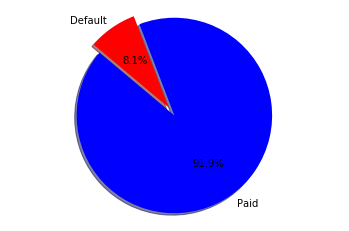

0    0.919271
1    0.080729
Name: target, dtype: float64


In [5]:
tar = data['target'].value_counts(normalize=1)

# Data to plot
labels = ['Paid', 'Default']
sizes = tar.values
colors = ['blue', 'red']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

print(tar)


#### Checking for NA's, variance and correlation with target variable 

In [6]:
# NA's table
na_table = pd.DataFrame({"Variable": data.isnull().sum().index,
                         "Na's Amount": data.isnull().sum().values,
                         "Na's Percent": data.isnull().sum().values*100/data.shape[0]})
na_table.set_index(["Variable"],inplace=True)

# correlation and variance table
corr_table = pd.DataFrame({"corr" :data.corr()['target'].abs(),
                           "variance":data.var()})

# joining the tables
na_table = na_table.join(corr_table)

In [7]:
# print top correlation var
na_table.sort_values(by="corr",ascending=False)[:20]

,Na's Amount,Na's Percent,corr,variance
Variable,,,,
target,0,0.000000,1.000000,7.421220e-02
ext_source_3,48974,19.907483,0.179441,3.801386e-02
ext_source_2,516,0.209749,0.161596,3.646571e-02
ext_source_1,138528,56.310364,0.154947,4.457925e-02
days_birth,0,0.000000,0.077700,1.906550e+07
region_rating_client_w_city,0,0.000000,0.060426,2.528882e-01
region_rating_client,0,0.000000,0.058012,2.589709e-01
days_last_phone_change,0,0.000000,0.055782,6.832105e+05
days_id_publish,0,0.000000,0.052459,2.277081e+06


We can notice the variables that have information about the building where the client lives suffer from multicollinearity (each variable has a mode, median, average).

for example:

In [8]:
data.loc[:,['floorsmin_avg','floorsmin_mode','floorsmin_medi','floorsmax_avg','floorsmax_mode','floorsmax_medi']].corr()

,floorsmin_avg,floorsmin_mode,floorsmin_medi,floorsmax_avg,floorsmax_mode,floorsmax_medi
floorsmin_avg,1.000000,0.986046,0.997352,0.742447,0.729350,0.740023
floorsmin_mode,0.986046,1.000000,0.988433,0.722966,0.727067,0.723708
floorsmin_medi,0.997352,0.988433,1.000000,0.740053,0.730022,0.740578
floorsmax_avg,0.742447,0.722966,0.740053,1.000000,0.985710,0.997141
floorsmax_mode,0.729350,0.727067,0.730022,0.985710,1.000000,0.988204
floorsmax_medi,0.740023,0.723708,0.740578,0.997141,0.988204,1.000000


Therefore, i remove all the "mode" and "medi" variables and keep the "avg" (they are the most correlated with the target). 

In [9]:
to_drop = ['apartments_mode', 'basementarea_mode','years_beginexpluatation_mode','years_build_mode','commonarea_mode','elevators_mode',
           'entrances_mode','floorsmax_mode','floorsmin_mode','landarea_mode','livingapartments_mode','livingarea_mode',
           'nonlivingapartments_mode','nonlivingarea_mode','apartments_medi','basementarea_medi','years_beginexpluatation_medi',
           'years_build_medi','commonarea_medi','elevators_medi','entrances_medi','floorsmax_medi','floorsmin_medi','landarea_medi',
           'livingapartments_medi','livingarea_medi','nonlivingapartments_medi','nonlivingarea_medi']

# Drop from the data-sets
for df in [data, holdout]:
    df.drop(columns=to_drop, inplace = True)

# Drop from the na_table as well
na_table.drop(to_drop, axis='index', inplace=True)

Another case of two variables representing almost the same information on how highly correlated.

In [10]:
data[['region_rating_client','region_rating_client_w_city']].corr()

,region_rating_client,region_rating_client_w_city
region_rating_client,1.00000,0.95098
region_rating_client_w_city,0.95098,1.00000


`region_rating_client_w_city` is more coralted with the target variable so i keep it.

In [11]:
to_drop = ['region_rating_client']
# Drop from the data-sets
for df in [data, holdout]:
    df.drop(columns=to_drop, inplace = True)

# Drop from the na_table as well
na_table.drop(to_drop, axis='index', inplace=True)

In [12]:
# print var with the most NA's
na_table.sort_values(by="Na's Percent",ascending=False)[:20]

,Na's Amount,Na's Percent,corr,variance
Variable,,,,
commonarea_avg,171830,69.847322,0.018041,0.005798
nonlivingapartments_avg,170798,69.427823,0.001611,0.002277
fondkapremont_mode,168191,68.368102,NaN,NaN
livingapartments_avg,168151,68.351842,0.025508,0.008552
floorsmin_avg,166871,67.831534,0.034256,0.026015
years_build_avg,163544,66.479139,0.022383,0.012829
own_car_age,162329,65.985253,0.038309,142.078019
landarea_avg,146029,59.359452,0.009226,0.006598
basementarea_avg,143880,58.485903,0.021095,0.006762


In [13]:
# print var with the most NA's
na_table.sort_values(by="variance",ascending=True)[:20]

,Na's Amount,Na's Percent,corr,variance
Variable,,,,
flag_mobil,0,0.000000,NaN,0.000000
flag_document_12,0,0.000000,0.000845,0.000008
flag_document_10,0,0.000000,0.001581,0.000028
flag_document_2,0,0.000000,0.004340,0.000049
flag_document_4,0,0.000000,0.002672,0.000081
flag_document_7,0,0.000000,0.001732,0.000179
region_population_relative,0,0.000000,0.036600,0.000191
flag_document_17,0,0.000000,0.002930,0.000260
flag_document_21,0,0.000000,0.003759,0.000325


### Near zero variance

If the variable has a variance lower than 0.001 and less than 5 categories, then it does not add information.

In [14]:
#remove near zero variance
for col in data.columns:
    if data[col].dtype != 'object':
        if data[col].var()<0.001:
            if len(data[col].unique()) < 5:
                
                print("{0} variable with {1} variance has been removed".format(col,data[col].var()))
                
                data.drop(columns=[col], inplace=True)
                holdout.drop(columns=[col], inplace=True)

flag_mobil variable with 0.0 variance has been removed
flag_document_2 variable with 4.8776720390913225e-05 variance has been removed
flag_document_4 variable with 8.129189021710357e-05 variance has been removed
flag_document_7 variable with 0.00017882470961036085 variance has been removed
flag_document_10 variable with 2.8453665218628923e-05 variance has been removed
flag_document_12 variable with 8.129783869425947e-06 variance has been removed
flag_document_17 variable with 0.00026008751838272395 variance has been removed
flag_document_19 variable with 0.0006337261801018158 variance has been removed
flag_document_20 variable with 0.0005200396758605112 variance has been removed
flag_document_21 variable with 0.0003250882478365397 variance has been removed


### Fix columns

In the `organization_type` variable I'm combining the different organization's types into the same class, and change XNA to np.nan.

In [15]:
data['organization_type'].unique()

array(['Business Entity Type 3', 'Business Entity Type 2', 'Security',
       'XNA', 'Business Entity Type 1', 'Government', 'Trade: type 7',
       'School', 'Transport: type 4', 'Kindergarten', 'Other',
       'Self-employed', 'Advertising', 'Insurance', 'Construction',
       'Industry: type 9', 'Trade: type 2', 'Military',
       'Industry: type 3', 'Medicine', 'Electricity', 'Housing',
       'Agriculture', 'Postal', 'Industry: type 7', 'Telecom',
       'Emergency', 'Transport: type 1', 'Industry: type 5',
       'Trade: type 3', 'Security Ministries', 'Industry: type 11',
       'Bank', 'Restaurant', 'Transport: type 3', 'University', 'Police',
       'Trade: type 1', 'Trade: type 6', 'Industry: type 2',
       'Transport: type 2', 'Hotel', 'Cleaning', 'Mobile', 'Services',
       'Industry: type 4', 'Industry: type 1', 'Industry: type 12',
       'Industry: type 6', 'Legal Services', 'Culture', 'Realtor',
       'Religion', 'Industry: type 13', 'Trade: type 4',
       'Industry

In [16]:
# organization_type
char = [':','\d+', 'Type', 'type']

for df in [data, holdout]:
    for c in char:
        df['organization_type'] = df['organization_type'].str.strip()
        df['organization_type'] = df['organization_type'].str.replace(c,'')
        df.loc[df['organization_type'] == 'XNA','organization_type'] = 'Not mentioned'

In `code_gender` there are 'XNA' values instead of NA. 

In [17]:
# code_gender
for df in [data, holdout]:
    df.loc[df['code_gender'] == 'XNA','code_gender'] = np.nan

The variables: `days_birth`,`days_employed`,`days_registration`,`days_id_publish` are in days and in negative values.
It would make more sense to convert them to years and positive values.

In [18]:
var_to_drop = ['days_birth','days_employed','days_registration','days_id_publish']

for df in [data,holdout]:
    df['age'] = df['days_birth']/-365
    df['years_employed'] = df['days_employed']/-365
    df['years_registration'] = df['days_registration']/-365
    df['years_id_publish'] = df['days_id_publish']/-365

    df.drop(columns=var_to_drop, inplace = True)


### Dealing with Na's

Remove any column with more than 60% missing values, except `own_car_age` because, in this case, Na means the customer has no car.
Later on, I will create a feature with regard to the car age.

Only 5 observations are really missing.

In [19]:
print("Missing values:", data['own_car_age'].isnull().sum())
print("Customers with no car:", sum(data['flag_own_car']=='N'))
print("NA's:", str((data['own_car_age'].isnull().sum())-(sum(data['flag_own_car']=='N'))))

Missing values: 162329
Customers with no car: 162324
NA's: 5


#### `own_car_age` variable

In [20]:
# List of the columns with more than 60% NA's
var_to_drop = list(na_table[na_table["Na's Percent"] > 60].index)
var_to_drop = var_to_drop[3:]     # Not including own_car_age, ext_source_1,occupation_type

# Drop from the data-sets
for df in [data, holdout]:
    df.drop(columns=var_to_drop, inplace = True)

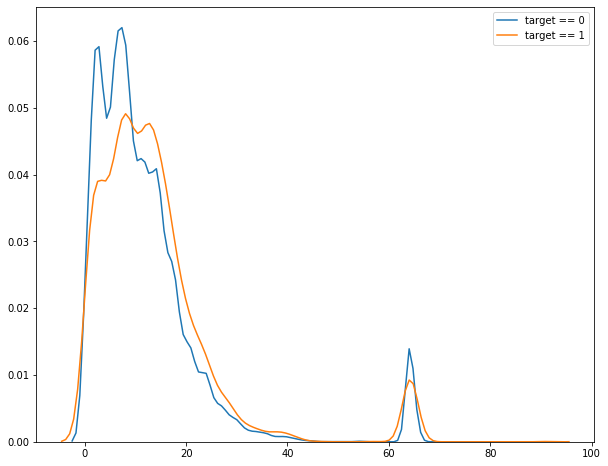

In [21]:
plt.figure(figsize = (10, 8))

sns.kdeplot(data.loc[data['target'] == 0, 'own_car_age'], label = 'target == 0')

sns.kdeplot(data.loc[data['target'] == 1, 'own_car_age'], label = 'target == 1')


In [22]:
# Bin the car age data

for df in [data, holdout]:
    df['own_car_age_binned'] = "Doesn't has car"
    
    df.loc[df['own_car_age'] <= 3, 'own_car_age_binned'] = "0-3"
    df.loc[(df['own_car_age'] > 3) & (df['own_car_age'] <= 5), 'own_car_age_binned'] = "3-5"
    df.loc[(df['own_car_age'] > 5) & (df['own_car_age'] <= 10), 'own_car_age_binned'] = "5-10"
    df.loc[(df['own_car_age'] > 10) & (df['own_car_age'] <= 15), 'own_car_age_binned'] = "10-15"
    df.loc[(df['own_car_age'] > 15) & (df['own_car_age'] <= 20), 'own_car_age_binned'] = "15-20"
    df.loc[(df['own_car_age'] > 20) & (df['own_car_age'] <= 40), 'own_car_age_binned'] = "20-40"
    df.loc[df['own_car_age'] > 40, 'own_car_age_binned'] = "40+"

In [23]:
# Drop the own_car_age variable

for df in [data, holdout]:
    df.drop(columns=['own_car_age'], axis=1, inplace = True)

In [24]:
pd.crosstab(data['target'], data['own_car_age_binned'],dropna=False, normalize=0)

own_car_age_binned,0-3,10-15,15-20,20-40,3-5,40+,5-10,Doesn't has car
target,,,,,,,,
0,0.065475,0.068234,0.039187,0.030449,0.030648,0.011333,0.097927,0.656747
1,0.045821,0.070342,0.043656,0.037563,0.019688,0.011883,0.075831,0.695217


#### `name_type_suite`  and `occupation_type` variables

In [25]:
for df in [data, holdout]:
    df['name_type_suite'].fillna('Not mentioned', inplace=True)
    df['occupation_type'].fillna('Not mentioned', inplace=True)

#### `amt_annuity` variable

There are only 11 cases that have no information about the periodic payment. Furthermore, all these cases came from non-default clients, so I remove these observations.

In [26]:
print("There are: " +str(data['amt_annuity'].isnull().sum())+"  missing values")
print("And they have: "+str(data.loc[data['amt_annuity'].isnull(), 'target'].sum())+"  default client")

for df in [data, holdout]:
    to_drop = list(df[df['amt_annuity'].isnull()].index)
    df.drop(to_drop, axis=0, inplace=True)

There are: 11  missing values
And they have: 0  default client


#### "amt_goods_price"  Varible

`amt_goods_price` is the price of the goods for which the loan is given.
Filling the missing value with the loan total amount (`amt_credit` variable).

In [27]:
for df in [data, holdout]:
    df.loc[df.amt_goods_price.isnull(),"amt_goods_price"] = df.loc[df.amt_goods_price.isnull(),"amt_credit"]   

## Feature Engineering

- `crdit_from_income` is the ratio between the credit amount relative to a client's income.

    A client with a high salary can take a higher loan without being a risky client, unlike a client with a low salary.


- `crdit_from_income_and_assets` is the ratio between the credit amount relative to a client's income plus the asset's value.

    Same as `crdit_from_income` but taking into consideration the asset's value.
    
    
- `credit_terms` is the length of the loan (define as the periodic payment divided by the total credit amount).
    
    It is reasonable to check whether the loan term affects the probability of being default.
    
    
- `employed_from_age` is the client's years of employment relative to the client's age.
    
    It could be a situation that the client has a relatively large amount of years of employment just because they are old people.

In [28]:
for df in [data, holdout]:
    df['crdit_from_income'] = df['amt_credit'] / df['amt_income_total']
    df['crdit_from_income_and_assets'] = df['amt_credit'] / (df['amt_income_total'] + df['amt_goods_price'])
    df['credit_terms'] = df['amt_annuity'] / df['amt_credit']
    df['employed_from_age'] = df['age'] / df['years_employed']

#### Create instrumental variable from the external sources

In [29]:
for df in [data, holdout]:    
    df['ext_source_1+2'] = df['ext_source_1'] * df['ext_source_2']
    df['ext_source_2+3'] = df['ext_source_2'] * df['ext_source_3']
    df['ext_source_1+3'] = df['ext_source_1'] * df['ext_source_3']
    df['ext_source_1+2+3'] = df['ext_source_1'] * df['ext_source_2'] * df['ext_source_3']

#### Create polynomial Features from the most correlated variables

In [30]:
for df in [data, holdout]: 
    df['ext_source_1^2'] = df['ext_source_1']**2
    df['ext_source_2^2'] = df['ext_source_2']**2
    df['ext_source_3^2'] = df['ext_source_3']**2
    df['age^2'] =df['age']**2
    df['region_rating_client_w_city^2'] = df['region_rating_client_w_city']**2

Check if there is a high correlation between the external sources variables

In [31]:
data[['ext_source_1','ext_source_2','ext_source_3','ext_source_1+2','ext_source_2+3','ext_source_1+3','ext_source_1+2+3']].corr()

,ext_source_1,ext_source_2,ext_source_3,ext_source_1+2,ext_source_2+3,ext_source_1+3,ext_source_1+2+3
ext_source_1,1.000000,0.212282,0.186948,0.807819,0.249198,0.761159,0.680861
ext_source_2,0.212282,1.000000,0.110362,0.695373,0.704299,0.196104,0.561008
ext_source_3,0.186948,0.110362,1.000000,0.188554,0.736821,0.727366,0.619295
ext_source_1+2,0.807819,0.695373,0.188554,1.000000,0.556909,0.640313,0.834975
ext_source_2+3,0.249198,0.704299,0.736821,0.556909,1.000000,0.634237,0.823467
ext_source_1+3,0.761159,0.196104,0.727366,0.640313,0.634237,1.000000,0.878491
ext_source_1+2+3,0.680861,0.561008,0.619295,0.834975,0.823467,0.878491,1.000000


## Preparing the data for modeling

### Categorical variables

Change the `name_contract_type` to `is_revolving_loans`.

In [32]:
# name_contract_type
for df in [data, holdout]:
    df['is_revolving_loans'] = 0
    df.loc[df['name_contract_type'] == 'Revolving loans','is_revolving_loans'] = 1
    df.drop(columns=['name_contract_type'], inplace=True)

In [33]:
cols = ['code_gender', 'flag_own_realty', 'emergencystate_mode','housetype_mode', 'wallsmaterial_mode']

encod = LabelEncoder()

for col in cols:
    # Transform from Y/N to 1/0 
    data[col] = encod.fit_transform(data[col].astype(str))
   
    # Transform the test set as well
    holdout[col] = encod.fit_transform(holdout[col].astype(str)) 

## Data Imputation

The data imputation strategy is to fill categorical variables with the mode (the most frequent value) and for continuous variables to fill with the median value.

In [34]:
# Replace infinity to NA
data.replace([np.inf, -np.inf], np.nan,inplace=True)
holdout.replace([np.inf, -np.inf], np.nan,inplace=True)

In [35]:
# Numeric Vriables
num_col = []
for col in data.columns:
    if data[col].dtype != 'object' and len(data[col].unique()):
        num_col.append(col)

for df in [data,holdout]:
    for col in num_col:
        df[col].fillna(data[col].median(), inplace=True)


In [36]:
# Categorical Vriables

cat_col = []
for col in data.columns:
    if data[col].dtype == 'object':
        cat_col.append(col)

for df in [data,holdout]:    
    for col in cat_col:
        df[col].fillna(data[col].mode(), inplace=True)        
        

## One-Hot Encoding for Multi-Categorical Variables

In [37]:
# One-Hot encoding function
def create_dummies(df, column_name):
    """
    Create dummy variable from categorical variable.
    """
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns = [column_name], inplace = True)
    return df

In [38]:
# One-Hot encoding for multi-category variables

for col in data.columns:
    if data[col].dtype == 'object':
        data = create_dummies(data, col)       
        
for col in holdout.columns:
    if holdout[col].dtype == 'object':
        holdout = create_dummies(holdout, col)          

There are 2 variables (which probably were classes in some categorical feature) in the train set and don't exist in the test set. 

In [39]:
data.shape, holdout.shape

((245997, 185), (61502, 183))

Finding and adding the missing columns to the test set with 0 values (which indicate that they not exist).

In [40]:
test_columns_list = holdout.columns.to_list()

for i in data.columns:
    if i not in test_columns_list:
        print(i)
        holdout[i] = 0

# Correct the order of the columns to be the same as the train set
holdout = holdout[data.columns]

name_income_type_Businessman
name_family_status_Unknown


## Scaling Numeric Variables

In [41]:
for col in data.columns:
    if data[col].dtype != 'object' and len(data[col].unique()) > 2:
        print(col)

code_gender
cnt_children
amt_income_total
amt_credit
amt_annuity
amt_goods_price
region_population_relative
cnt_fam_members
region_rating_client_w_city
hour_appr_process_start
ext_source_1
ext_source_2
ext_source_3
apartments_avg
basementarea_avg
years_beginexpluatation_avg
years_build_avg
commonarea_avg
elevators_avg
entrances_avg
floorsmax_avg
landarea_avg
livingarea_avg
nonlivingarea_avg
housetype_mode
totalarea_mode
wallsmaterial_mode
emergencystate_mode
obs_30_cnt_social_circle
def_30_cnt_social_circle
obs_60_cnt_social_circle
def_60_cnt_social_circle
days_last_phone_change
amt_req_credit_bureau_hour
amt_req_credit_bureau_day
amt_req_credit_bureau_week
amt_req_credit_bureau_mon
amt_req_credit_bureau_qrt
amt_req_credit_bureau_year
age
years_employed
years_registration
years_id_publish
crdit_from_income
crdit_from_income_and_assets
credit_terms
employed_from_age
ext_source_1+2
ext_source_2+3
ext_source_1+3
ext_source_1+2+3
ext_source_1^2
ext_source_2^2
ext_source_3^2
age^2
region_ra

In [42]:
# return values between 0-1 
scaler = MinMaxScaler() # X_new = Xi-min(X) / max(X)-min(X) 


for col in data.columns:
    if data[col].dtype != 'object':                        # only numeric values
        if len(data[col].unique()) > 2:                    # exclude dummies  
            data[col] = scaler.fit_transform(data[[col]])
            holdout[col] = scaler.transform(holdout[[col]])

### Split to X and y for train and test sets

In [43]:
# Save the variables names
features = list(data.columns)

# Split the data to train and test
X_train = data.drop('target',axis=1)
y_train = data['target']

X_test = holdout.drop('target',axis=1)
y_test = holdout['target']

In [44]:
print(X_train.shape, X_test.shape,'\n')
print(y_train.shape, y_test.shape)

(245997, 184) (61502, 184) 

(245997,) (61502,)


# Models

## Naive Model

Obviously just by saying every client has 0% to become a default we can get to ~92% accuracy.

That's the reason we are using the ROC AUC score which receives only 0.5 (equal to randomly choice) with that naive model.

In [89]:
pred= [0] * y_test.shape[0]
print("Test ROC AUC Score: " + str(roc_auc_score(y_test, pred)) +'\n')
print("Classification Report: \n"+ str(classification_report(pred, y_test, digits=5)))

Test ROC AUC Score: 0.5

Classification Report: 
              precision    recall  f1-score   support

           0    1.00000   0.91927   0.95794     61502
           1    0.00000   0.00000   0.00000         0

    accuracy                        0.91927     61502
   macro avg    0.50000   0.45964   0.47897     61502
weighted avg    1.00000   0.91927   0.95794     61502



## Machine Learning Algorithms

In [47]:
# Define models
lr = LogisticRegression()
rf = RandomForestClassifier()
adb = AdaBoostClassifier()
xgb = XGBClassifier()

svm = SVC()                        # Not used
knn = KNeighborsClassifier()       # Not used

In [45]:
%%time
# Getting cross validation scores for each model

models = [lr, rf, adb, xgb]
    
for model in models:
    model.fit(X_train, y_train)
    name = model.__class__.__name__
    result = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
    print("{}s score: {}".format(name, result.mean()))

LogisticRegressions score: 0.7462382313674982
RandomForestClassifiers score: 0.7230782117398697
AdaBoostClassifiers score: 0.7476033806641009
XGBClassifiers score: 0.7554759103433085
Wall time: 13min 31s


# Hyperparameter Tuning

One option for a smarter implementation of hyperparameter tuning is to combine random search and grid search:

1. Use random search with a large hyperparameter grid
2. Use the results of random search to build a focused hyperparameter grid around the best performing hyperparameter values.
3. Run grid search on the reduced hyperparameter grid.
4. Select the best hyperparameter tuning.

## Random Search

In [48]:
## Grids

# Logistic Regression
lr_grid = {
    "solver": ['saga'],
    "penalty": ['l1', 'l2','elasticnet'],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 300, 1000] ,
    "l1_ratio": np.arange(0.1, 0.9, 0.05) 
}  

# Random Forest
rf_grid = {
    "n_estimators": [50, 100, 200, 350, 500],
    "max_features": ['auto', 'sqrt'],
    "max_depth": [3, 5, 6, 8, 10],
    "min_samples_split": list(np.linspace(0.01, 1.0, 10, endpoint=True).round(2)),
    "min_samples_leaf": list(np.linspace(0.01, 1.0, 10, endpoint=True).round(2))
}  


# Adaboost
adb_grid = {
    "n_estimators": [50, 100, 250, 500],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators": [100, 250, 500]
}

# Xgboost
xgb_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators": [500],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "min_child_weight": np.arange(1, 10, 1),
    "gamma": np.arange(0, 10, 1),
    "colsample_bytree": np.arange(0.5 ,1, 0.1),
    "max_depth":[3, 5, 6, 8, 10]
    }


## Not Used
# KNN
knn_grid = {
    "n_neighbors": np.arange(1,100,2),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": np.arange(2,30,2),
    "p": [1,2]
}

# SVM
svm_grid = {
    "C": [0, 0.001, 0.01, 0.1, 1, 3, 5, 10, 50, 100],
    "gamma": [0, 0.001, 0.01, 0.1, 1, 3, 5, 10, 50, 100],
    "kernel": ["rbf"]
}

In [49]:
%%time
models = [lr, rf, adb, xgb]
grids = [lr_grid, rf_grid, adb_grid, xgb_grid]

for model, grid in list(zip(models, grids)):
    name = model.__class__.__name__
    model = RandomizedSearchCV(estimator=model, param_distributions=grid,
                               scoring='roc_auc', n_jobs=-1,
                               cv = 3, random_state = 1234)
    model.fit(X_train, y_train)
    
    print('Model: ', name,'\n')
    print('Best Score: ', model.best_score_,'\n')
    print('Best Params: ', model.best_params_)
    print('==========================================================================')

Model:  LogisticRegression 

Best Score:  0.7473101699826458 

Best Params:  {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.6500000000000001, 'C': 100}
Model:  RandomForestClassifier 

Best Score:  0.5 

Best Params:  {'n_estimators': 350, 'min_samples_split': 0.45, 'min_samples_leaf': 0.45, 'max_features': 'sqrt', 'max_depth': 3}
Model:  AdaBoostClassifier 

Best Score:  0.7518935627838467 

Best Params:  {'n_estimators': 500, 'learning_rate': 0.1}
Model:  XGBClassifier 

Best Score:  0.7667547956752201 

Best Params:  {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 6, 'colsample_bytree': 0.7}
Wall time: 3h 21min 33s


## Grid Search

Base on the random search result we are making new grids for the best 3 models.

In [60]:
# Logistic Regression
lr_grid = {
    "solver": ['saga'],
    "penalty": ['l1'],
    "C": [50, 80 ,100, 120, 150, 200]
}  

# Adaboost
adb_grid = {
    "n_estimators": [500],
    "learning_rate": [0.075, 0.1, 0.15, 0.2],
}
    
# Xgboost
xgb_grid = {
    "learning_rate": [0.025, 0.05, 0.075],
    "n_estimators": [500],
    "subsample":[0.7, 0.8, 0.9],
    "min_child_weight": [6, 7, 8],
    "gamma": [6],
    "colsample_bytree": [0.7],
    "max_depth":[5]
    }



In [61]:
%%time
models = [lr, adb, xgb]
grids = [lr_grid, adb_grid, xgb_grid]

for model, grid in list(zip(models, grids)):
    name = model.__class__.__name__
    model = GridSearchCV(estimator=model, param_grid=grid,
                               scoring='roc_auc', n_jobs=-1, cv = 3)
    model.fit(X_train, y_train)
    
    print('Model: ', name,'\n')
    print('Best Score: ', model.best_score_,'\n')
    print('Best Params: ', model.best_params_)
    print('==========================================================================')

Model:  LogisticRegression 

Best Score:  0.7473105761209614 

Best Params:  {'C': 150, 'penalty': 'l1', 'solver': 'saga'}
Model:  AdaBoostClassifier 

Best Score:  0.7557093314566536 

Best Params:  {'learning_rate': 0.2, 'n_estimators': 500}
Model:  XGBClassifier 

Best Score:  0.7670413152351153 

Best Params:  {'colsample_bytree': 0.7, 'gamma': 6, 'learning_rate': 0.075, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.9}
Wall time: 4h 32min 4s


## Deep Neural Network

In [108]:
def fc_model(n_hidden=6, n_neurons=20, learning_rate=1e-3, input_dim=X_train.shape[1], dropout = 0.2):
    model = keras.models.Sequential()
    options = {"input_dim": input_dim}

    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="elu", **options))
        model.add(keras.layers.Dropout(dropout))
        options = {}

    # last layer the output
    model.add(keras.layers.Dense(1, activation='sigmoid', **options))
    optimizer = Adam(learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[keras.metrics.AUC()])
    return model

In [105]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(fc_model)

## ANN Hyperparameter Tuning

In [106]:
%%time

# Setting the parameters ranges

params = {
    "n_hidden": tuple([1,2,3]),   
    "n_neurons": tuple([20, X_train.shape[1], 500]),
    "learning_rate": tuple([1e-2, 1e-3, 1e-4]),
    "dropout": tuple([0.0, 0.2])
}

# Random search grid 
rnd_search = RandomizedSearchCV(keras_clf, params, random_state=1234, n_iter=20,
                                cv=ShuffleSplit(n_splits=1, test_size= 0.001, random_state=1234)) # To prevent doing cross-validation

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=0)
mcp = ModelCheckpoint(filepath='weights1.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=1e-7 ,verbose=0)

history = rnd_search.fit(X_train, y_train, epochs=50,
                  validation_split=0.2,
                  callbacks=[es, mcp, rlr],
                  verbose=0)

246/246 [==============================] - 0s 73us/step
Wall time: 4h 53min 27s


In [107]:
print(rnd_search.best_params_)

{'n_neurons': 20, 'n_hidden': 1, 'learning_rate': 0.01, 'dropout': 0.2}


Choose the best model

In [109]:
%%time

# Assign the best parameters to the new model
model = fc_model(n_hidden=1, n_neurons=20, learning_rate=1e-03, dropout=0.2)

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train, epochs=50,
                  validation_split=0.2,
                  callbacks=[es, rlr, mcp],
                  verbose=1)

Train on 196797 samples, validate on 49200 samples
Epoch 1/50
196797/196797 [==============================] - 32s 162us/step - loss: 0.2575 - auc_4: 0.7160 - val_loss: 0.2557 - val_auc_4: 0.7334

Epoch 00001: val_loss improved from inf to 0.25569, saving model to weights.h5
Epoch 2/50
196797/196797 [==============================] - 30s 154us/step - loss: 0.2537 - auc_4: 0.7300 - val_loss: 0.2547 - val_auc_4: 0.7366

Epoch 00002: val_loss improved from 0.25569 to 0.25471, saving model to weights.h5
Epoch 3/50
196797/196797 [==============================] - 30s 154us/step - loss: 0.2528 - auc_4: 0.7333 - val_loss: 0.2553 - val_auc_4: 0.7368

Epoch 00003: val_loss did not improve from 0.25471
Epoch 4/50
196797/196797 [==============================] - 31s 156us/step - loss: 0.2520 - auc_4: 0.7358 - val_loss: 0.2546 - val_auc_4: 0.7361

Epoch 00004: val_loss improved from 0.25471 to 0.25456, saving model to weights.h5
Epoch 5/50
196797/196797 [==============================] - 31s 158us

In [115]:
def plot_history(History,Metric = 'auc_4'):
    metric = History.history[Metric]
    val_metric = History.history['val_'+ str(Metric)]
    loss = History.history['loss']
    val_loss = History.history['val_loss']
    epochs = range(len(metric))

    plt.plot(epochs, metric, 'r--', label='Training ' + str(Metric))
    plt.plot(epochs, val_metric, 'b', label='Validation ' + str(Metric))
    plt.title('Training and validation '+ str(Metric))
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

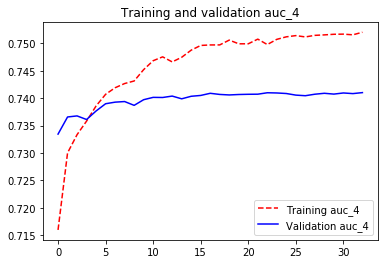

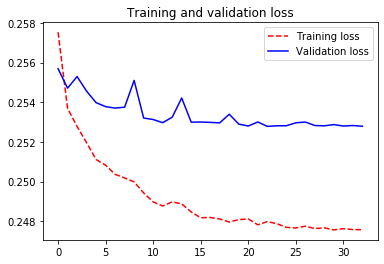

In [116]:
plot_history(history)

In [117]:
pred = model.predict_proba(X_test)

In [118]:
print("ROC AUC Score: " + str(roc_auc_score(y_test, pred)) +'\n')

ROC AUC Score: 0.7435162450363362



# Best Results

In [62]:
xgb = XGBClassifier(colsample_bytree=0.7, gamma=6, learning_rate=0.075, max_depth=5,
                    min_child_weight=7, n_estimators=500, subsample=0.9)

xgb.fit(X_train, y_train)

pred = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC Score: " + str(roc_auc_score(y_test, pred)))

ROC AUC Score: 0.768908220251134


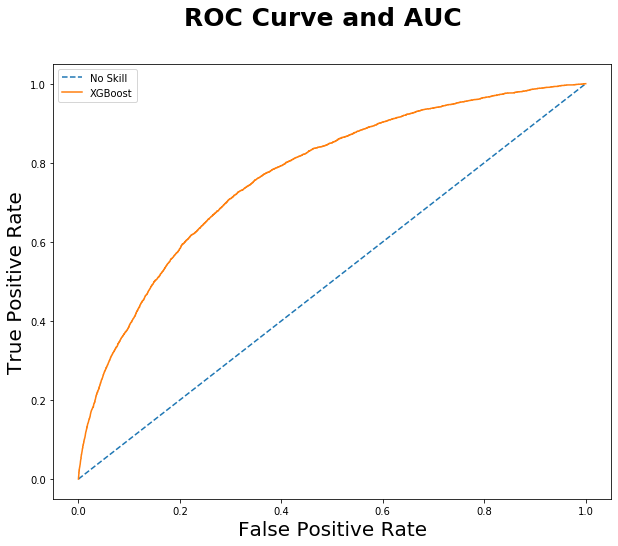

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.769


In [81]:
plt.figure(figsize = (10, 8))

# Generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# Calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
pred_auc = roc_auc_score(y_test, pred)

# Calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pred_fpr, pred_tpr, _ = roc_curve(y_test, pred)

# Plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(pred_fpr, pred_tpr, label='XGBoost')

plt.suptitle('ROC Curve and AUC', fontsize=25, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend()

plt.show()

# Summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (pred_auc))


## Feature Importances

In [75]:
importances = xgb.feature_importances_

importance_table = pd.DataFrame([features[1:],importances]).T
importance_table = importance_table.sort_values(1,ascending=True)[-25:]
importance_table

,0,1
77,age^2,0.0080794
19,reg_city_not_live_city,0.00866496
41,def_30_cnt_social_circle,0.00876702
69,employed_from_age,0.00915327
104,name_family_status_Married,0.00936124
14,region_rating_client_w_city,0.0093635
6,amt_goods_price,0.00939029
118,occupation_type_Core staff,0.00951254
70,ext_source_1+2,0.00961636
22,ext_source_1,0.009822


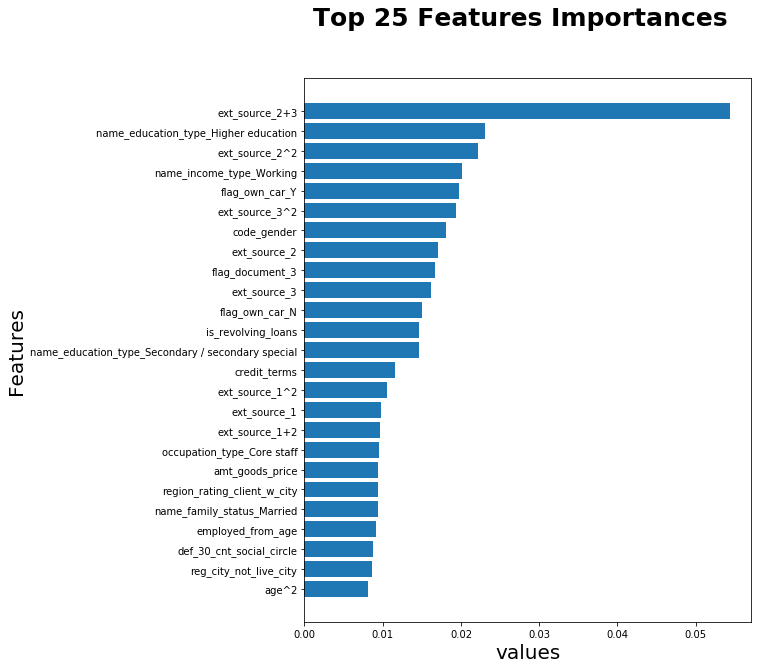

In [76]:
height = importance_table[1] 
bars = importance_table[0]

fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(bars, height)
fig.suptitle('Top 25 Features Importances', fontsize=25, fontweight='bold')

plt.xlabel('values', fontsize=20)
plt.ylabel('Features', fontsize=20)
 
plt.show()